# El Viejo XOR: Métodos No-lineales para Problemas No-lineales

### a.  Escriba una función que genere (aleatoriamente) n datos etiquetados de la forma {(x 1 , y 1 ), . . . , (x n , y n )} ... Graficar

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

def do_XOR(n=1000,noisy_n=100,svm=True):
    rng = np.random.RandomState(0)
    X_train = rng.uniform(low=-1.0,high=1.0,size=(n,2))
    Y_train = np.logical_xor(X_train[:,0] > 0, X_train[:,1] > 0)
    Y_train = 2*Y_train-1 if svm else Y_train
    X_noisy= rng.uniform(low=-0.8,high=0.2,size=(noisy_n,2))
    Y_noisy = -1*np.logical_xor(X_noisy[:,0] > 0, X_noisy[:,1] > 0) + 1
    Y_noisy = 2*Y_noisy-1 if svm else Y_noisy
    X_train = np.vstack((X_train, X_noisy))
    Y_train = np.hstack((Y_train, Y_noisy))
    X_test = rng.uniform(low=-1.0,high=1.0,size=(n,2))
    Y_test = np.logical_xor(X_test[:,0] > 0, X_test[:,1] > 0)    
    Y_test = 2*Y_test - 1 if svm else Y_test
    return X_train,Y_train,X_test,Y_test

Se generan los datasets de entrenamiento y de prueba. Tener en cuenta que la función genera 2 clases con etiquetas -1 y 1, adecuado para su uso con SVMs.

In [3]:
X_train, Y_train, X_test, Y_test = do_XOR()

#### Gráficas de los datasets

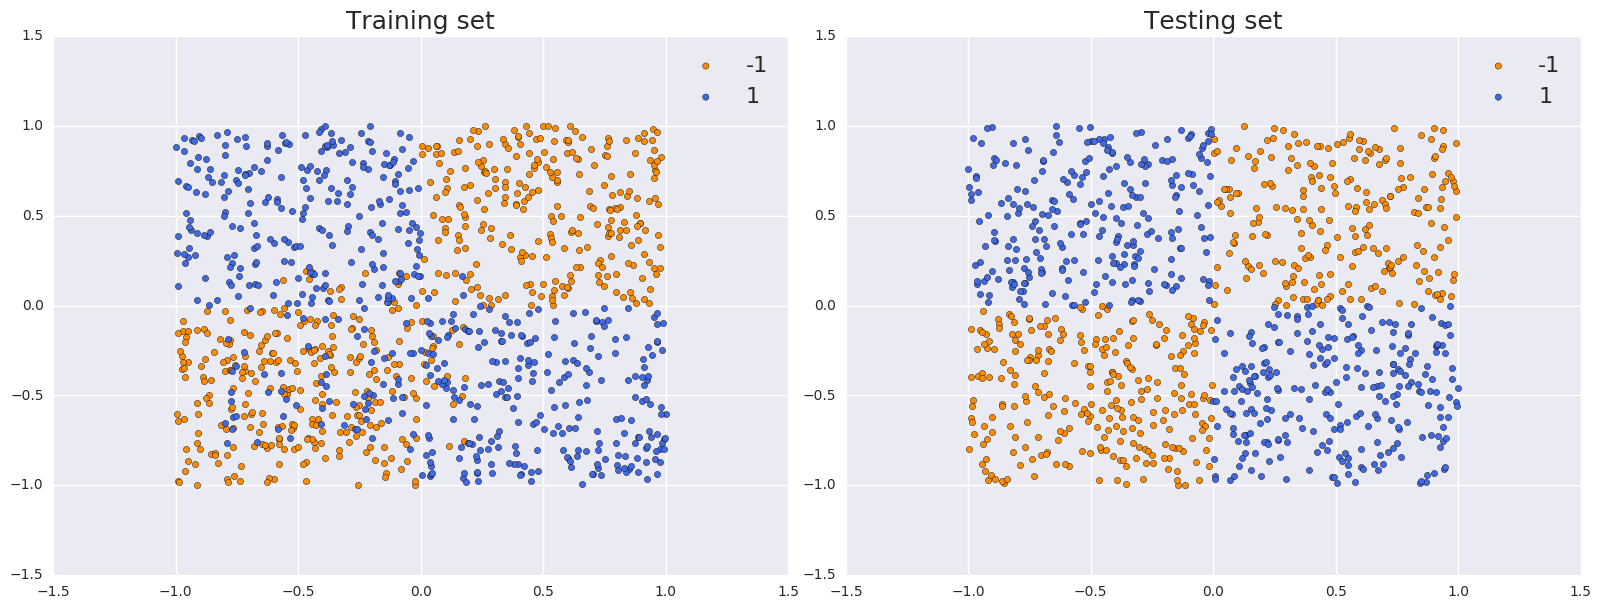

In [4]:
from matplotlib.colors import ListedColormap
mclasses = [-1, 1]
colors = ['darkorange', 'royalblue']
fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
fig.tight_layout()

for lab, col in zip(mclasses, colors):
     axs[0].scatter(X_train[Y_train == lab, 0], X_train[Y_train == lab, 1], label=lab, c=col)

axs[0].set_title('Training set', size=18)        
axs[0].legend(loc='upper right', fancybox=True, prop={'size':16})

for lab, col in zip(mclasses, colors):
     axs[1].scatter(X_test[Y_test == lab, 0], X_test[Y_test == lab, 1], label=lab, c=col)

axs[1].set_title('Testing set', size=18)        
axs[1].legend(loc='upper right', fancybox=True, prop={'size':16})

¿Porqué tiene sentido denominar este problema XOR? En este caso, los datos se distribuyen aleatoriamente en el cuadrado [-1, 1] X [-1, 1], el cual puede ser dividido en cuatro cuadrantes, los cuales son representados por las esquinas de coordenadas {(-1, 1), (1, 1), (1, -1), (-1, -1)}. En consecuencia, de acuerdo al cuadrante donde se encuentre un dato se definirá una entrada, la que a través del operador lógico OR exclusivo (XOR, denotado por el símbolo $\oplus$), generará la clase correspondiente tal como sigue: 

|Entrada | Operación | Clase |
|--------|-----------|-------|
|(-1, 1) |-1$\oplus$1| 1     |
|(1, 1)  |1$\oplus$1| -1    |
|(1, -1) |1$\oplus$-1| 1     |
|(-1, -1)|-1$\oplus$-1| -1    |

### b.  Demostración experimental de que una SVM lineal no es capaz de resolver satisfactoriamente el XOR classification problem. 

Pero antes, se define la función **plot_classifier**, que grafica el hiperplano o frontera de clasificación  que genera un modelo.

In [5]:
def plot_classifier(clf, X_train, Y_train, X_test, Y_test, model_type):
    f, axis = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(6, 6))
    axis.scatter(X_train[:,0], X_train[:,1], s=5, c=Y_train, zorder=10, cmap='gray')
    axis.scatter(X_test[:,0], X_test[:,1], s=15, c=Y_test, zorder=10, cmap='gray')
    XX, YY = np.mgrid[-1:1:200j, -1:1:200j]
    if model_type == 'svm':
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    elif model_type == 'tree':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    elif model_type == 'ann':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    else: 
        raise ValueError('model type not supported')
    
    Z = Z.reshape(XX.shape)
    Zplot = Z > 0 if model_type == 'svm' else Z > 0.5
    axis.pcolormesh(XX, YY, Zplot, cmap='YlGn')
    axis.contour(XX, YY, Z, alpha=1, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-1, 0, 1])

Se cargan las métricas para evaluar los distintos modelos.

In [6]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score)

#### Baseline

Con un Dummy classifier, se establece un baseline de rendimiento sobre el testing set. En este caso, las predicciones serán generadas de forma aleatoria y uniformemente.

In [7]:
from sklearn.dummy import DummyClassifier as DC
dc_model = DC('uniform')
dc_model.fit(X_train, Y_train)
dummy_prediction = dc_model.predict(X_test)
print "Accuracy: {}".format(accuracy_score(Y_test, dummy_prediction))
print "Precision: {}".format(precision_score(Y_test, dummy_prediction))
print "Recall: {}".format(recall_score(Y_test, dummy_prediction))

Accuracy: 0.503
Precision: 0.514
Recall: 0.502935420744


#### Evaluación de SVM usando normas l1 y l2

A continuación, se establecen los modelos de SVM lineales a evaluar. En este caso son dos tipos, cada uno basado en un norma distinta de regularición: L1 y L2. El parámetro de regularización se varía dentro de un intervalo log-espaciado. Para cada norma, se grafican las métricas accuracy, precision y recall en función de dicho parámetro.

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


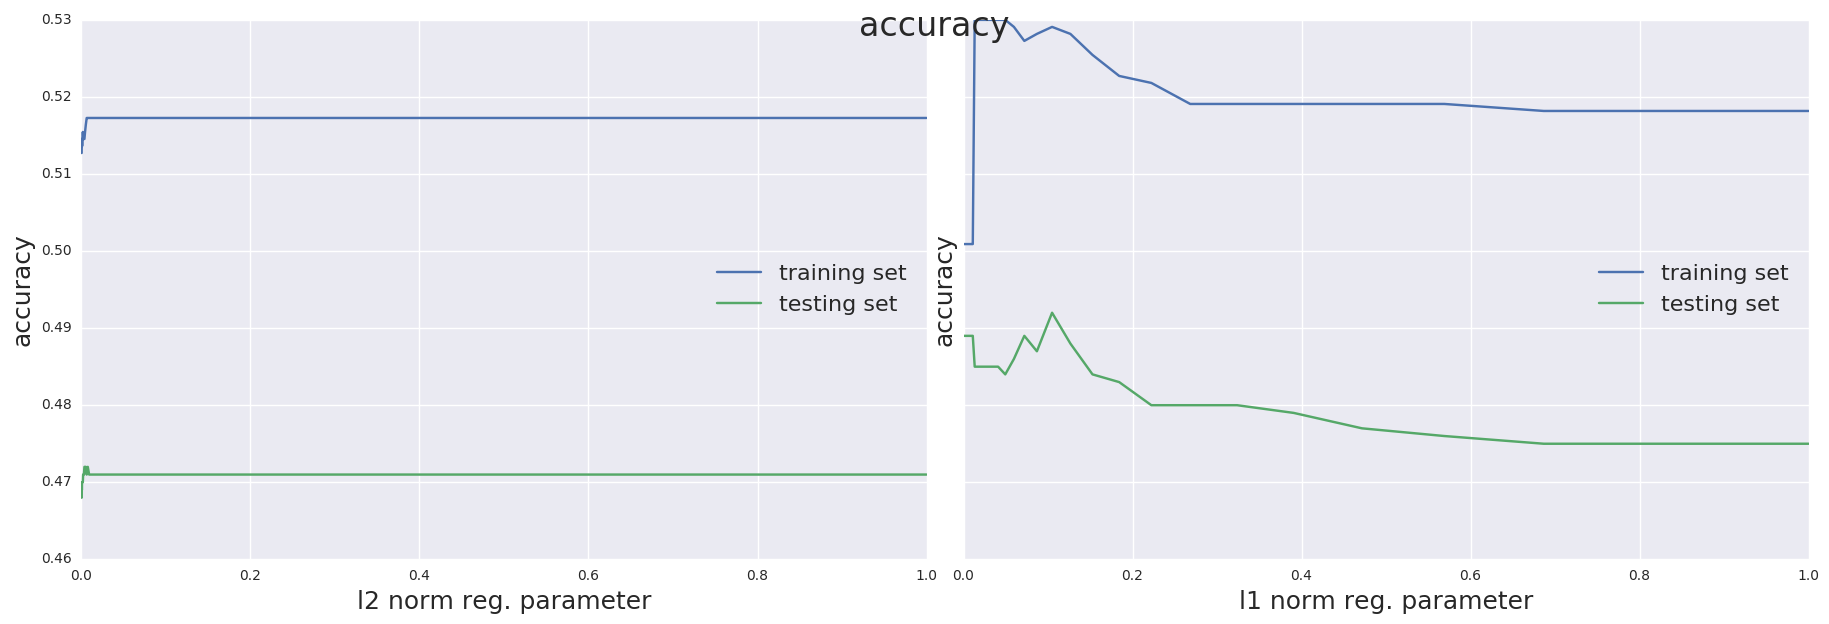

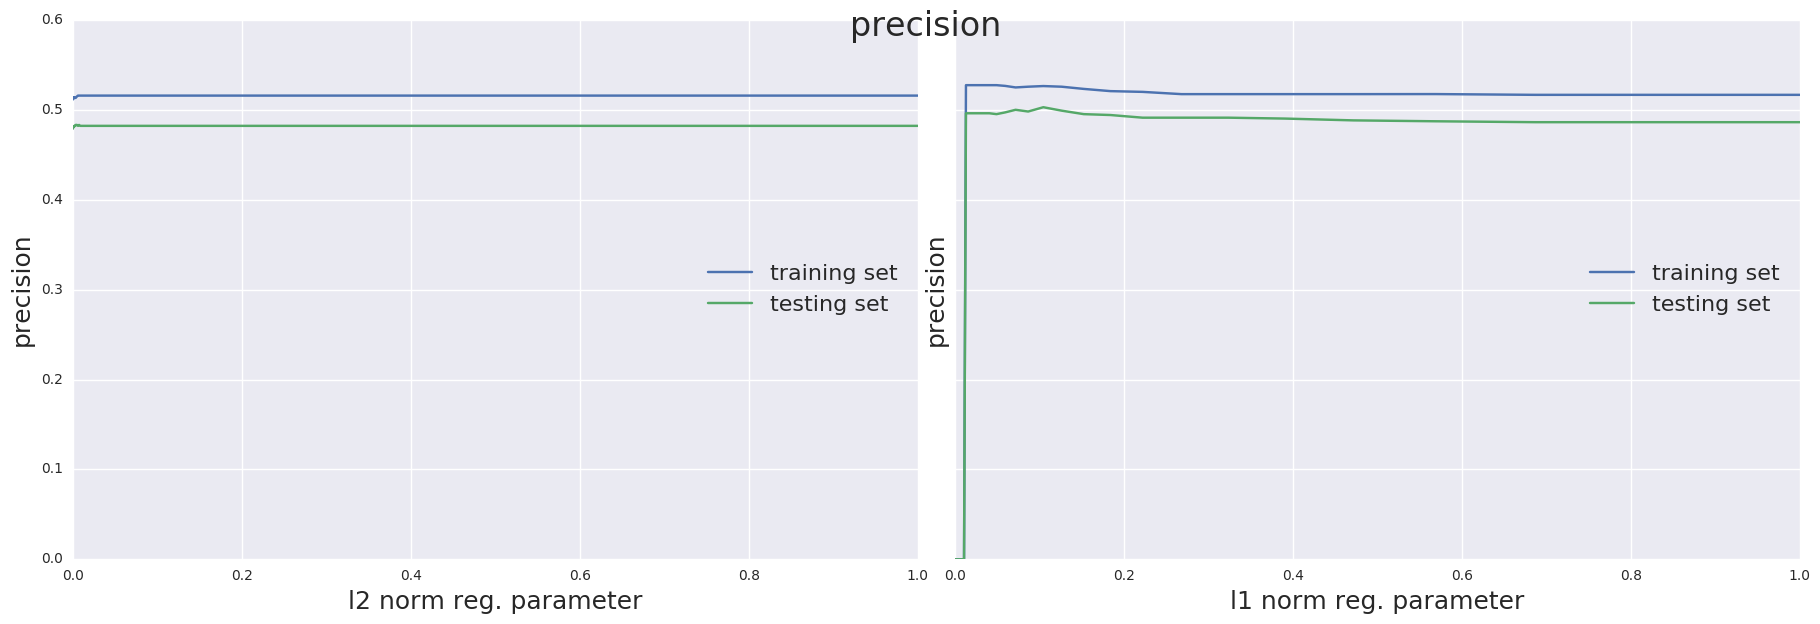

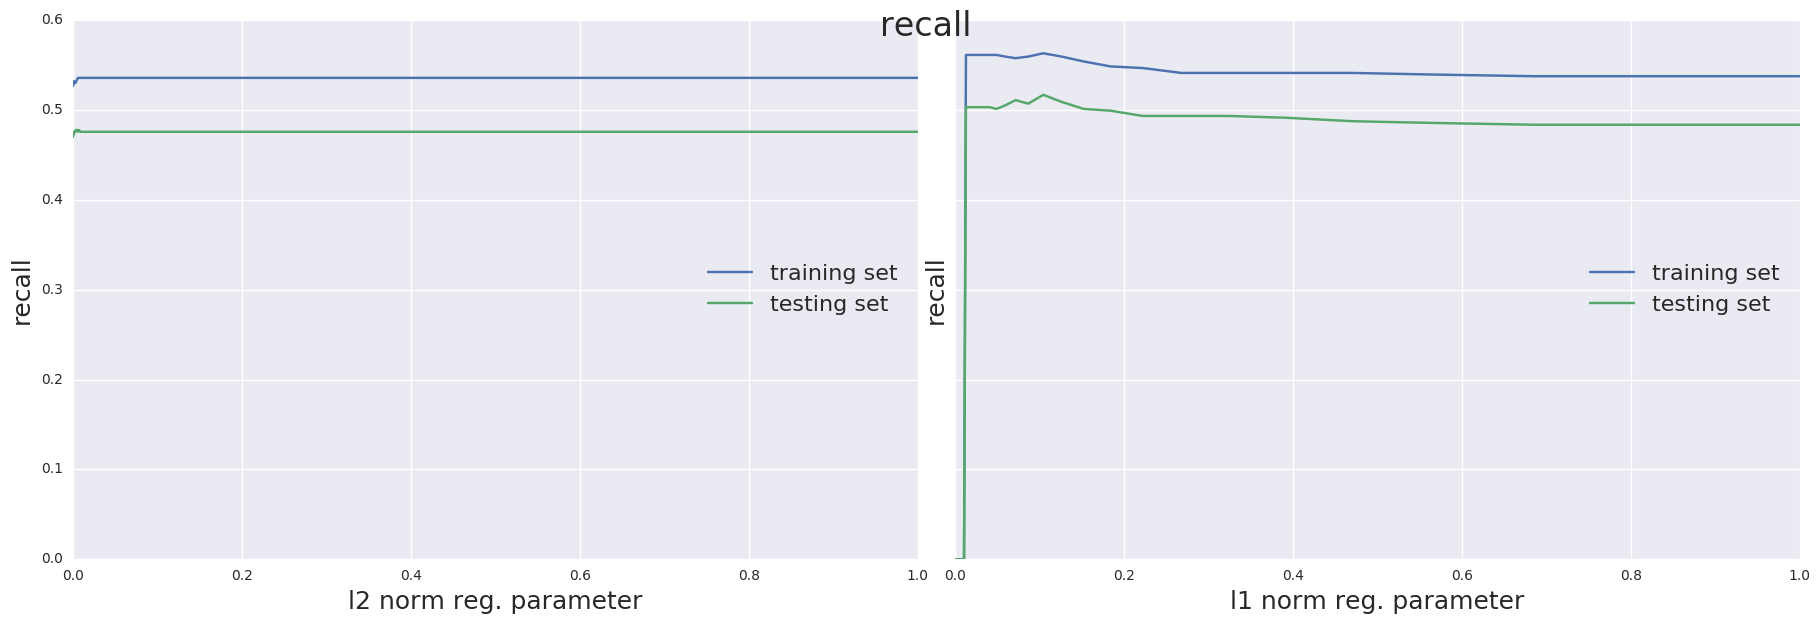

In [8]:
from sklearn.svm import LinearSVC

lsvm_models = {
    'l1': LinearSVC(penalty='l1',  tol=1e-3, dual=False),
    'l2': LinearSVC(penalty='l2',  tol=1e-5)
    }

lsvm_scores = {
    'l1':{score:{'training':[], 'testing':[]} for score in ['accuracy', 'precision', 'recall']},
    'l2':{score:{'training':[], 'testing':[]} for score in ['accuracy', 'precision', 'recall']}
    }

Cs = np.logspace(-4, 0)

for norm, model in lsvm_models.iteritems():
    for C in Cs:
        model.set_params(C=C)
        model.fit(X_train, Y_train)    
        Y_train_pred = model.predict(X_train)
        Y_test_pred = model.predict(X_test)
        lsvm_scores[norm]['accuracy']['training'].append((C, accuracy_score(Y_train, Y_train_pred)))
        lsvm_scores[norm]['precision']['training'].append((C, precision_score(Y_train, Y_train_pred)))
        lsvm_scores[norm]['recall']['training'].append((C, recall_score(Y_train, Y_train_pred)))    
        lsvm_scores[norm]['accuracy']['testing'].append((C, accuracy_score(Y_test, Y_test_pred)))
        lsvm_scores[norm]['precision']['testing'].append((C, precision_score(Y_test, Y_test_pred)))
        lsvm_scores[norm]['recall']['testing'].append((C, recall_score(Y_test, Y_test_pred)))


for score in ['accuracy', 'precision', 'recall']:        
    fig, axs = plt.subplots(ncols=2, figsize=(18, 6), sharey=True)
    fig.tight_layout()
    fig.suptitle(score, size=24)
    for i, norm in enumerate(lsvm_scores.keys()):
        for dataset_type, datapoints in lsvm_scores[norm][score].iteritems():
            axs[i].plot(*zip(*datapoints), label=dataset_type + ' set')
            axs[i].legend(loc="center right", prop={'size':16})  
            axs[i].set_xlabel(norm + ' norm reg. parameter', size=18)
            axs[i].set_ylabel(score, size=18)

Primero, en relación al accuracy, no se se observa una gran variación de tal métrica, al cambiar el parámetro de regularización. Con la norma l1 y parámetro de regularización aproximado de 0.1, el accuracy alcanza su tope, pero luego desciende hasta llegar a un valor estable. Considerando ambos sets de datos (training y testing), la SVM con norma l1 obtiene mejores resultados que con la norma l2. Además, considerando solo el testing set, con ambas normas, el rendimiento del clasificador está por debajo del 50% de exactitud. 

Segundo, en relación a la precisión, comparando entre ambas normas, no se observan diferencias significativas. Considerando ambos datasets, el rendimiento está en torno al 50%. El parámetro de regularización no parece influir significativamente. 

Tercero, en relación al recall, se observa un comportamiento análogo al visto con la precisión. 

Finalmente, comparando con el baseline generado a través de un clasificador que predice de forma uniformemente aleatoria, la SVM lineal no presenta un redimiento distinto, considenrado las tres métricas expuestas, por lo que este último modelo no resuelve satisfactoriamente el XOR classification problem. 

#### Gráficas de los hiperplanos generados por los modelos

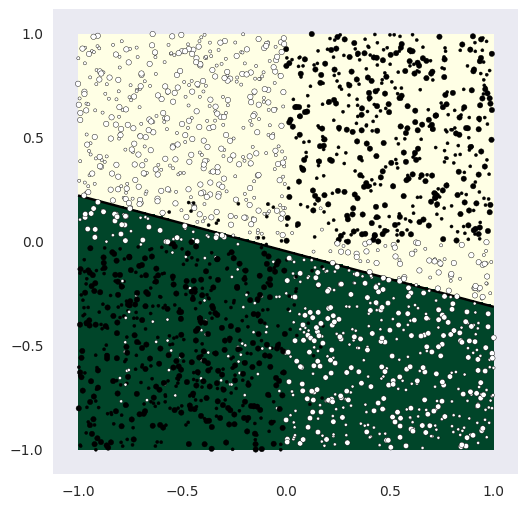

In [9]:
plot_classifier(lsvm_models['l2'], X_train, Y_train, X_test, Y_test, 'svm')

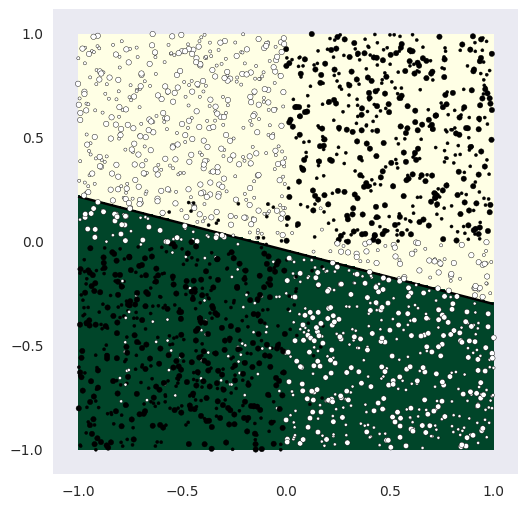

In [10]:
plot_classifier(lsvm_models['l1'], X_train, Y_train, X_test, Y_test, 'svm')

En las gráficas de arriba se pueden observar los hiperplanos generados por la SVM lineal (l2 primero, l1 después) que establecen las fronteras de clasificación. En ambos casos, tales fronteras de caracter lineal que no logran separa satisfactoriamente las clases, etiquetando mal la mitad de los datos. 

### c.  Demostrar experimentalmente que una SVM con un kernel no lineal puede resolver satisfactoriamente el XOR classification problem

Se defininen dos modelos SVM, uno con un kernel rbf y otro polinomial. Se realiza un prueba inicial, con parámetros predefinidos.

In [11]:
from sklearn.svm import SVC
from IPython.display import HTML

non_linear_svc = {'rbf': SVC(C=100, kernel='rbf'), 'poly': SVC(C=10, kernel='poly', degree=2, coef0=1)}

table_begin = "<table>"
table_headers = "<tr>" + "<td>Kernel</td>" + "<td>Accuracy</td>" + "<td>Precision</td>" + "<td>Recall</td>" + "</tr>"
table_end = "</table>" 
table_body = ""
for kernel, model in non_linear_svc.iteritems():
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    scores = [accuracy_score(Y_test, Y_pred), precision_score(Y_test, Y_pred), recall_score(Y_test, Y_pred)]
    row = "<tr>" + "<td>{}</td>".format(kernel) + "".join(["<td>{0:.4f}</td>".format(score) for score in scores]) + "</tr>"
    table_body += row

HTML(table_begin + table_headers + table_body + table_end)

En la tabla de arriba se observa que ambos modelos, resuelven satisfactoriamente el XOR classification problem, considerando que las tres métricas alcanzan un valor por sobre el 95% en la mayoría de los casos. Si se considera el baseline establecido, claramente una SVM con kernel no lineal resuelve de forma exitosa el problema.  

#### Error en función del parámetro de penalización C
A continuación se varía el parámetro de penalización para ambos modelos, para luego observar la variación del error de clasificación.

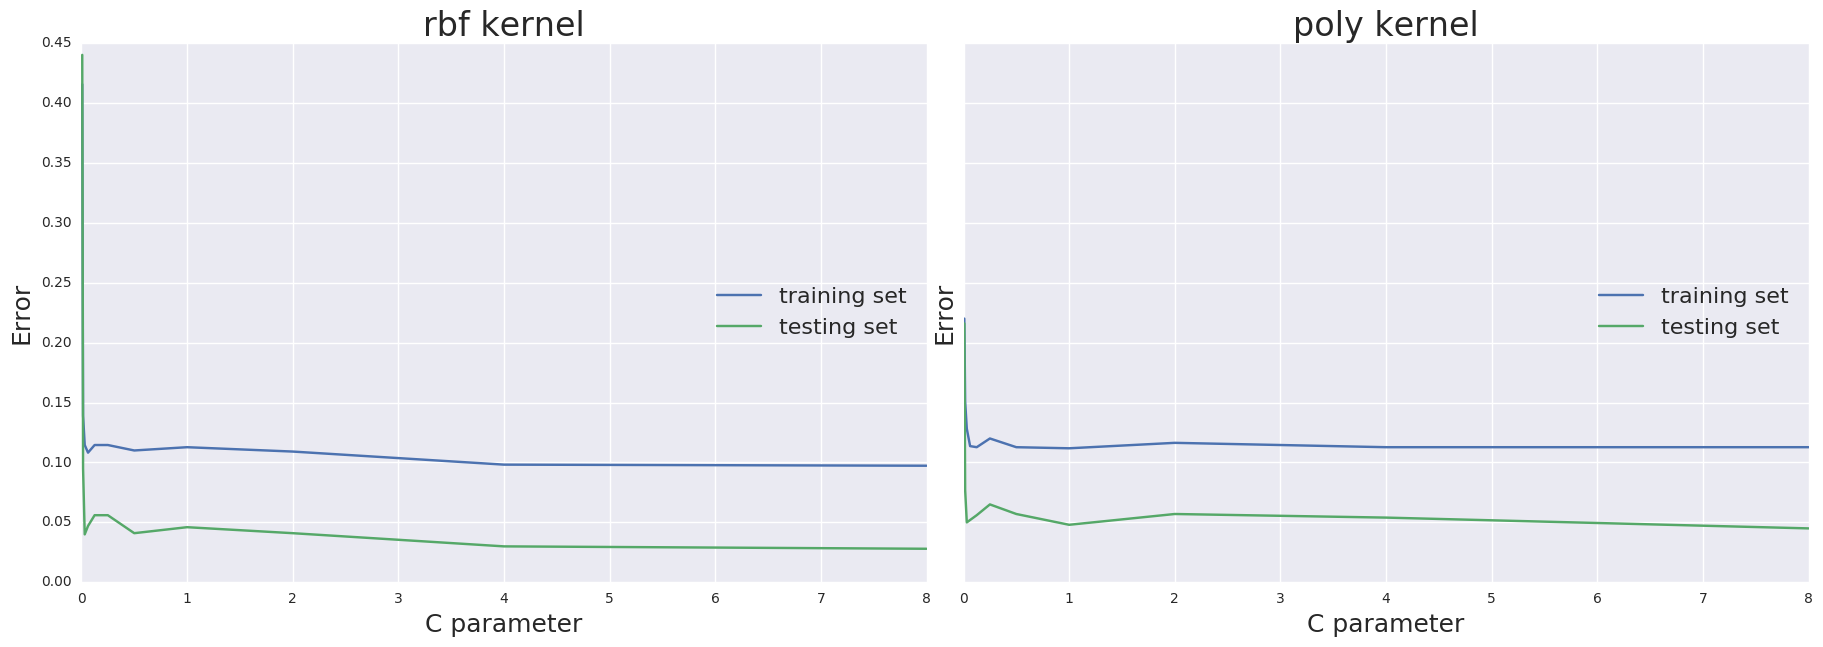

In [12]:
K = np.arange(-7, 4)
fig, axs = plt.subplots(ncols=2, figsize=(18, 6), sharey=True)
fig.tight_layout()
# fig.suptitle(score, size=24)
for i, kernel in enumerate(non_linear_svc.keys()):
    datapoints = {'training':[], 'testing':[]}
    model = non_linear_svc[kernel]
    for k in K:
        model.set_params(C=2**k)
        model.fit(X_train, Y_train)
        datapoints['training'].append((2**k, 1 - model.score(X_train, Y_train)))
        datapoints['testing'].append((2**k, 1 - model.score(X_test, Y_test)))
    axs[i].plot(*zip(*datapoints['training']), label='training set')
    axs[i].plot(*zip(*datapoints['testing']), label='testing set')
    axs[i].set_xlabel('C parameter', size=18)
    axs[i].set_ylabel('Error', size=18)
    axs[i].legend(loc="center right", prop={'size':16})  
    axs[i].set_title(kernel + ' kernel', size=24)

Se observa que con valores muy pequeños del parámetro C de penalizacón, el error aumenta incluso por sobre el 40% en el caso del kernel rbf. Sin embargo, a partir de un C igual a 0.5 o 1, el error no parece variar significativamente. Es interesante ver como el error es menor en el testing set. Comúnmente, y de acuerdo a las tareas anteriores, la siguación es la opuesta. Sin embargo, si se observan las gráficas de ambos sets de datos en el item **a**, se tiene que el training set posee *ruido*, es decir, elementos que en teoría son de determinada clase, pero en realidad son clasificados como la otra. En cambio el testing set, no cuenta con esas perturbaciones.


#### Gráficas de los hiperplanos generados por los modelos

A continuación, se genera la función **plot_svc** adaptación de **plot_classifier**, para graficar la influencia del parámetro de penalización C sobre los hiperplanos generados por los modelos, además del accuracy respectivo. Solamente se utiliza el testing set.

In [13]:
def plot_svc(clf, X_train, Y_train, X_test, Y_test, K):
    if len(K) > 5:
        return
    
    w = 30.0
    h = w/len(K)
    fig, axs = plt.subplots(ncols=len(K), sharex='col', sharey='row', figsize=(w, h))
    fig.tight_layout()
    for i, k in enumerate(K):
        clf.set_params(C=2**k)
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
        axs[i].scatter(X_train[:,0], X_train[:,1], s=5, c=Y_train, zorder=10, cmap='gray')
        axs[i].scatter(X_test[:,0], X_test[:,1], s=15, c=Y_test, zorder=10, cmap='gray')
        XX, YY = np.mgrid[-1:1:200j, -1:1:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
        Z = Z.reshape(XX.shape)
        Zplot = Z > 0
        axs[i].pcolormesh(XX, YY, Zplot, cmap='YlGn')
        axs[i].contour(XX, YY, Z, alpha=1, colors=['red', 'k', 'red'], linestyles=['--', '-', '--'], levels=[-1, 0, 1])
        axs[i].set_title('C = {}'.format(2**k), size=30)
        axs[i].set_xlabel('Testing score: {}'.format(score), size=30)    

**Gráfica SVM con kernel rbf**

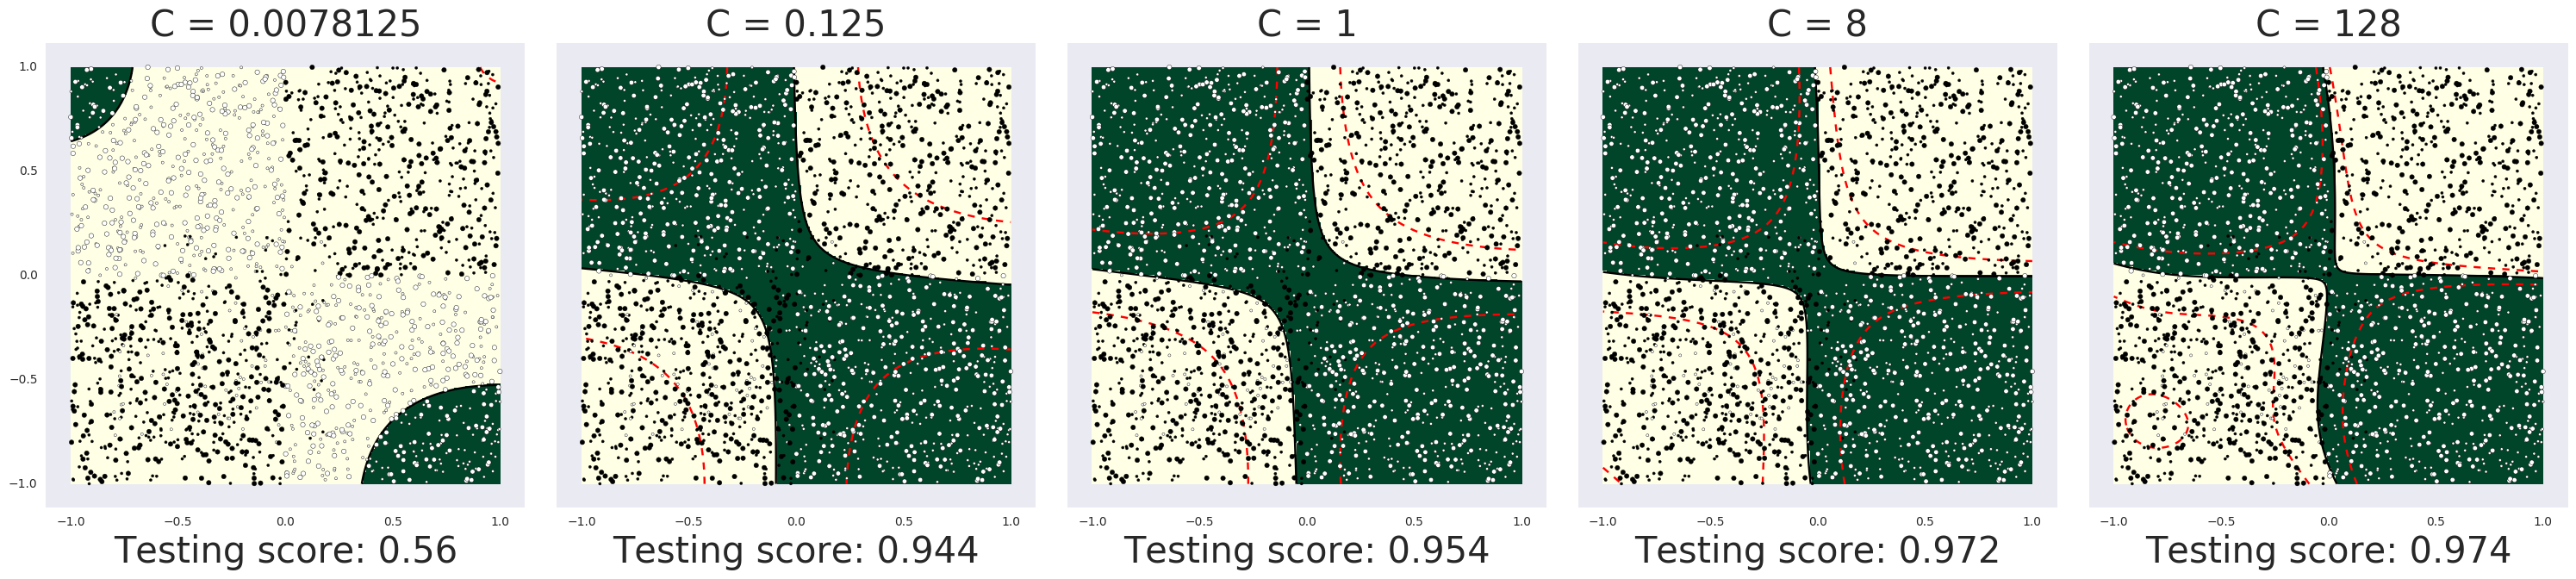

In [14]:
plot_svc(non_linear_svc['rbf'], X_train, Y_train, X_test, Y_test, [-7, -3, 0, 3, 7])

Arriba se puede observar la evolución del hiperplano generado por la SVM con kernel rbf, al cambiar el parámetro C. Se observa que a medida que este último aumenta, la frontera de clasificación se ajusta de mejor manera al como están distribuidos los datos en los cuatro cuadrantes del espacio, considerando además a la clase que pertenecen cada uno. Con un C = 0.0078125, el rendimiento del clasificador es bastante malo. Sin embargo con un C = 0.125 el rendimiento es bastante bueno. Posteriormente el desempeño no mejora significativamente. 

**Gráfica SVM con kernel polinomial**

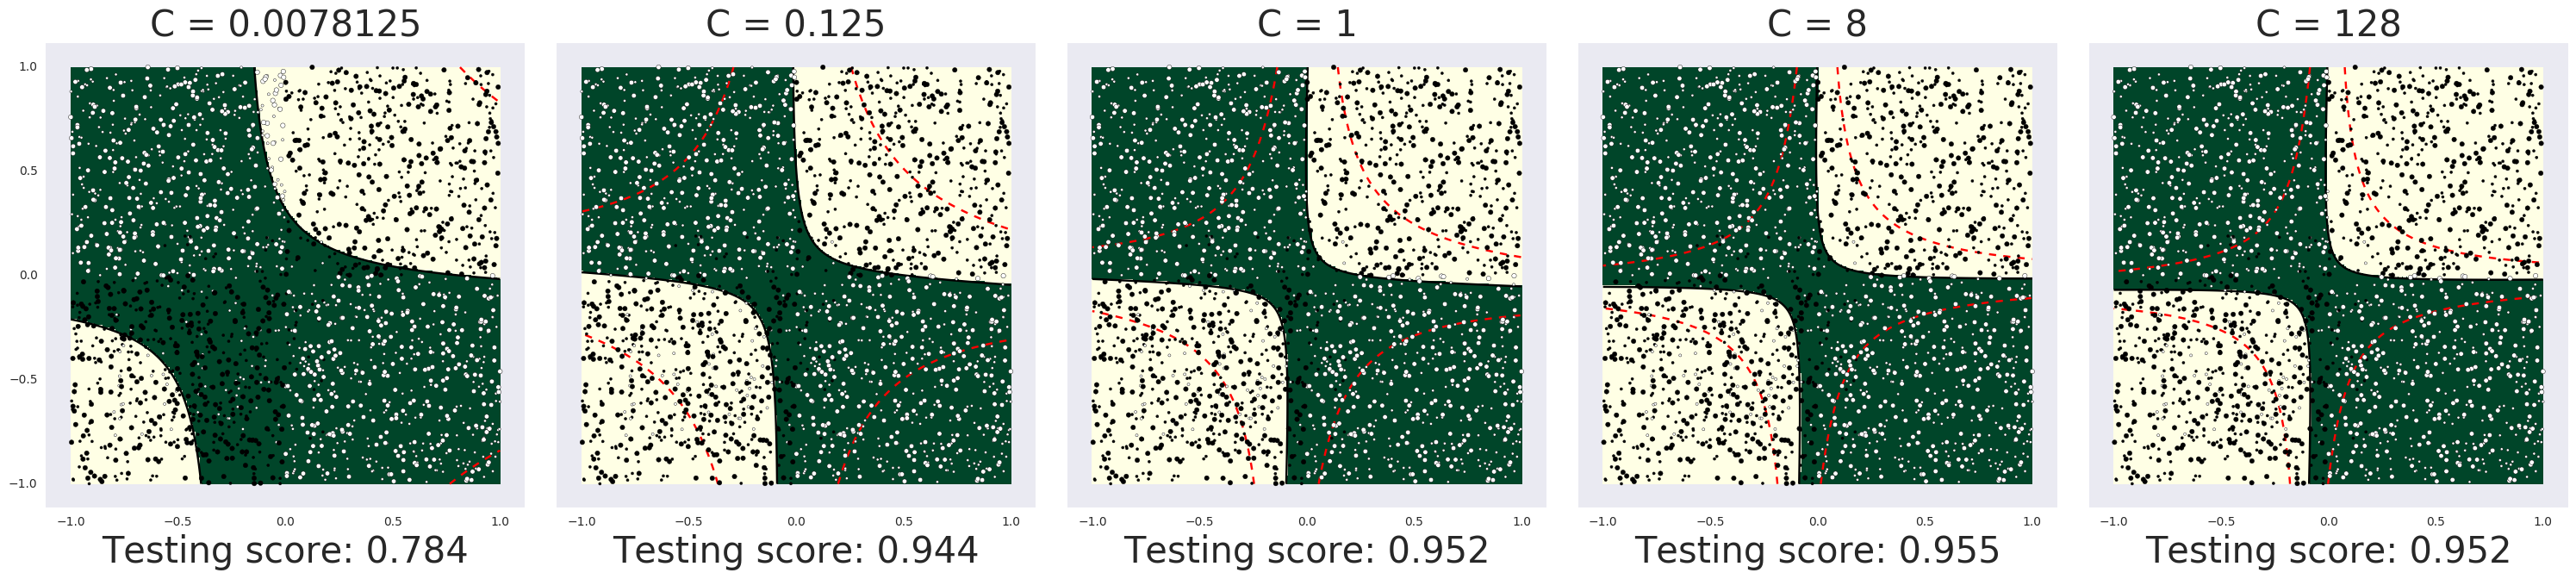

In [15]:
plot_svc(non_linear_svc['poly'], X_train, Y_train, X_test, Y_test, [-7, -3, 0, 3, 7])

Análogamente que con el kernel rbf, el accuracy en el testing set aumenta a medida que aumenta C. Desde C=0.125 en adelante, las variaciones del accuracy son mínimas.

### d. Red neuronal sin capas escondidas

Generación de un nuevo conjunto de datasets de entrenamiento y de pruebas, cambiando el parámetro svm a False, lo cual hace que las dos clases generadas posean etiquetas iguales a 0 y 1.

In [16]:
X_train, Y_train, X_test, Y_test = do_XOR(svm=False)

Gráficas de los datasets generados.

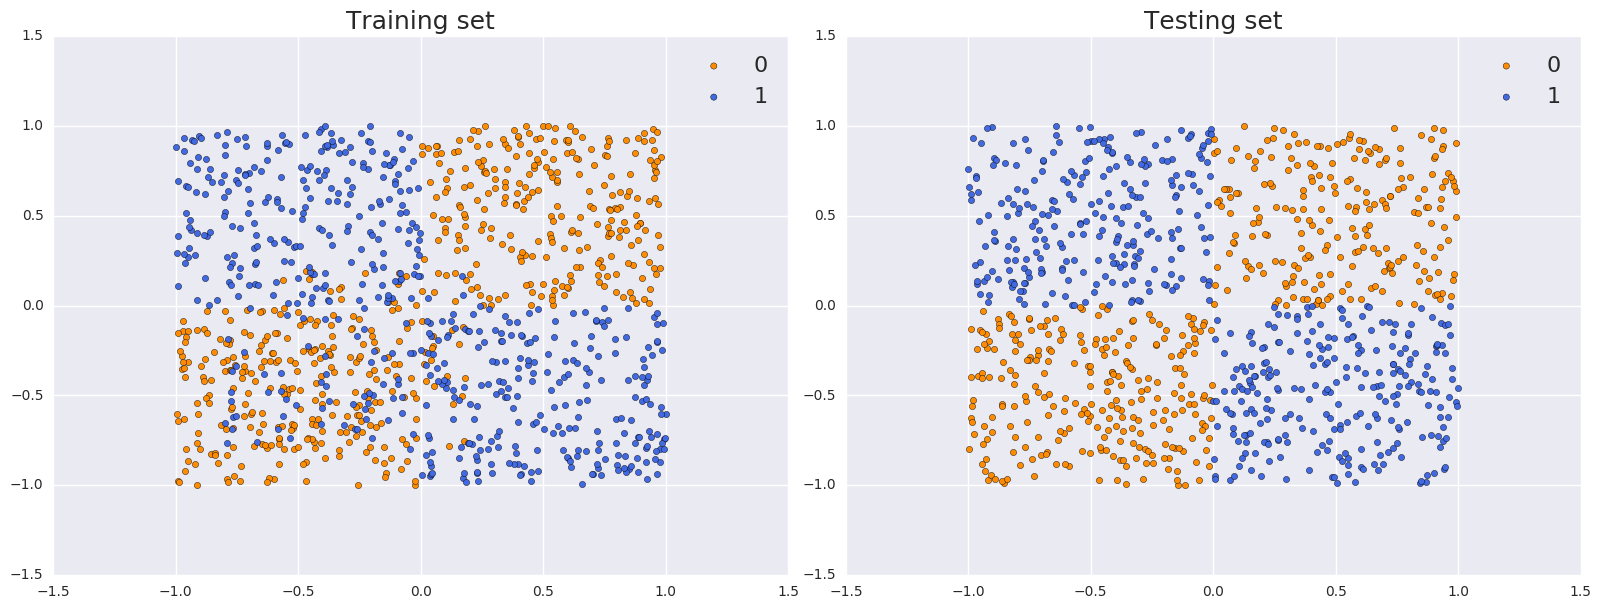

In [26]:
mclasses = [0, 1]
colors = ['darkorange', 'royalblue']
fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
fig.tight_layout()

for lab, col in zip(mclasses, colors):
     axs[0].scatter(X_train[Y_train == lab, 0], X_train[Y_train == lab, 1], label=lab, c=col)

axs[0].set_title('Training set', size=18)        
axs[0].legend(loc='upper right', fancybox=True, prop={'size':16})

for lab, col in zip(mclasses, colors):
     axs[1].scatter(X_test[Y_test == lab, 0], X_test[Y_test == lab, 1], label=lab, c=col)

axs[1].set_title('Testing set', size=18)        
axs[1].legend(loc='upper right', fancybox=True, prop={'size':16})

Carga de los módulos necesarios.

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


#### Perceptrón con función de activación sigmoidal
Se configuran tres modelos de perceptrones, cada uno con una función de activación distinta para la capa de entrada.

In [18]:
activation_functions = ['sigmoid', 'relu', 'tanh']
perceptron_models = []

for f in activation_functions:
    perceptron = Sequential()
    perceptron.add(Dense(1, input_dim=X_train.shape[1], init='uniform', activation=f))
    perceptron.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
    perceptron.fit(X_train, Y_train, nb_epoch=50, batch_size=100, verbose=0)
    perceptron_models.append(perceptron)

    loss, accu = perceptron.evaluate(X_test, Y_test)
    print "\nActivation function: {}".format(f)
    print "Testing loss: {}".format(loss)
    print "Testing accuracy: {}".format(accu)

 864/1000 [========================>.....] - ETA: 0s
Activation function: sigmoid
Testing loss: 0.696446160316
Testing accuracy: 0.494
 960/1000 [===========================>..] - ETA: 0s
Activation function: relu
Testing loss: 7.79582614899
Testing accuracy: 0.0
 640/1000 [==================>...........] - ETA: 0s
Activation function: tanh
Testing loss: 7.79582633209
Testing accuracy: 0.511


Como puede apreciarse arriba, los tres modelos obtienen resultados mediocres, iguales o menores al baseline establecido (alrededor de un 50 % de exactitud en las predicciones) por lo que los resultados son para nada satisfactorios. En todo caso, lo anterior era esperable, dada la naturaleza no lineal del problema XOR y la arquitectura de las redes neuronales testeadas. En estas últimas, al no poseer capa oculta alguna, la respuesta o salida es simplemente una combinación lineal de los $m$ inputs y sus pesos correspondientes, cuyo hiperplano separador separador se define como:

$$\sum_{i=1}^{m}w_ix_i + b = 0$$

A continuación, se grafican los hiperplanos separadores para cada uno de los modelos de perceptrones. 

#### Perceptron con función de activación sigmoidal

39296/40000 [============================>.] - ETA: 0s

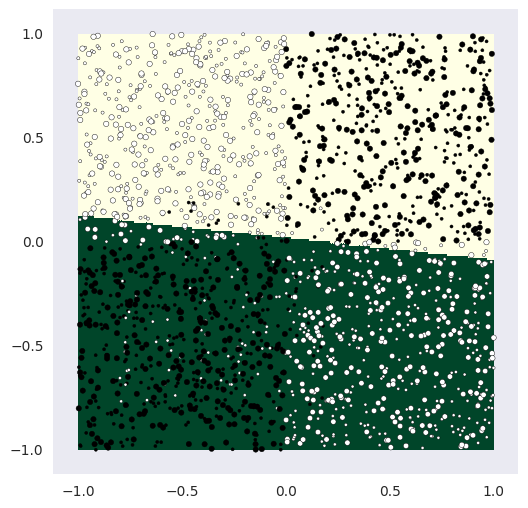

In [19]:
plot_classifier(perceptron_models[0], X_train, Y_train, X_test, Y_test, 'ann')

#### Perceptrón con función de activación relu

39840/40000 [============================>.] - ETA: 0s

/usr/local/lib/python2.7/dist-packages/keras/models.py:767: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


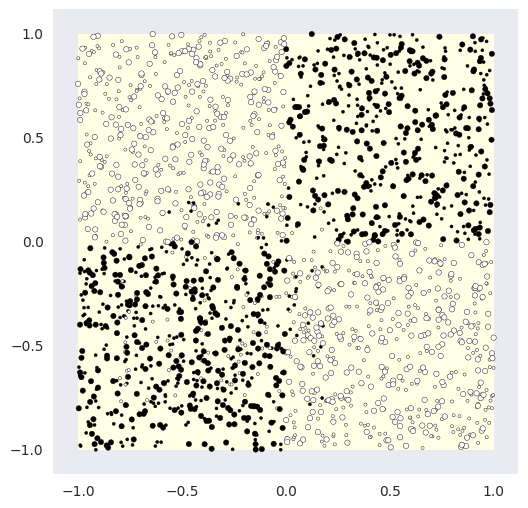

In [20]:
plot_classifier(perceptron_models[1], X_train, Y_train, X_test, Y_test, 'ann')

#### Perceptrón con función de activación tangencial

39520/40000 [============================>.] - ETA: 0s

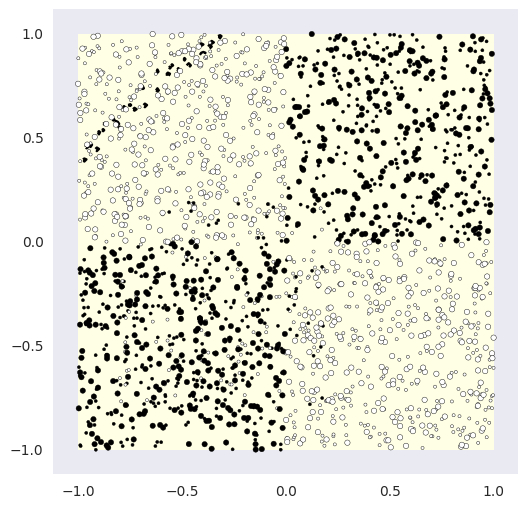

In [21]:
plot_classifier(perceptron_models[2], X_train, Y_train, X_test, Y_test, 'ann')

### e. Red neuronal con una capa de nodos escondidos

Esta vez, se prueban modelos de redes neuronales con una capa escondida. Se consideran tres funciones de activación de la capa oculta: sigmoidal, tangente y relu. El número de nodos de esta capa se varía dentro del siguiente conjunto de valores $\{2, 4, 8, 16, 32, 64, 128\}$.

In [22]:
K = np.arange(1, 8)
activation_funcs = ['sigmoid', 'tanh', 'relu']
scores_data = {func:{'training':[], 'testing':[]} for func in activation_funcs} 
ann_models = {func:[] for func in activation_funcs}

for func in activation_funcs:
    for k in K:
        n_h = 2**k
        model = Sequential()
        model.add(Dense(n_h, input_dim=X_train.shape[1], init='uniform', activation=func))
        model.add(Dense(1, init='uniform', activation='sigmoid'))
        model.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, Y_train, nb_epoch=50, batch_size=100, verbose=0)
        ann_models[func].append(model)

        # Training set
        loss, accu = model.evaluate(X_train, Y_train, verbose=0)        
        scores_data[func]['training'].append((n_h, 1 - accu))

        # Testing set
        loss, accu = model.evaluate(X_test, Y_test, verbose=0)
        scores_data[func]['testing'].append((n_h, 1 - accu))

A continuación se grafica el error de clasificación, tanto para el de training como el de testing, en función del número de nodos en la capa oculta.

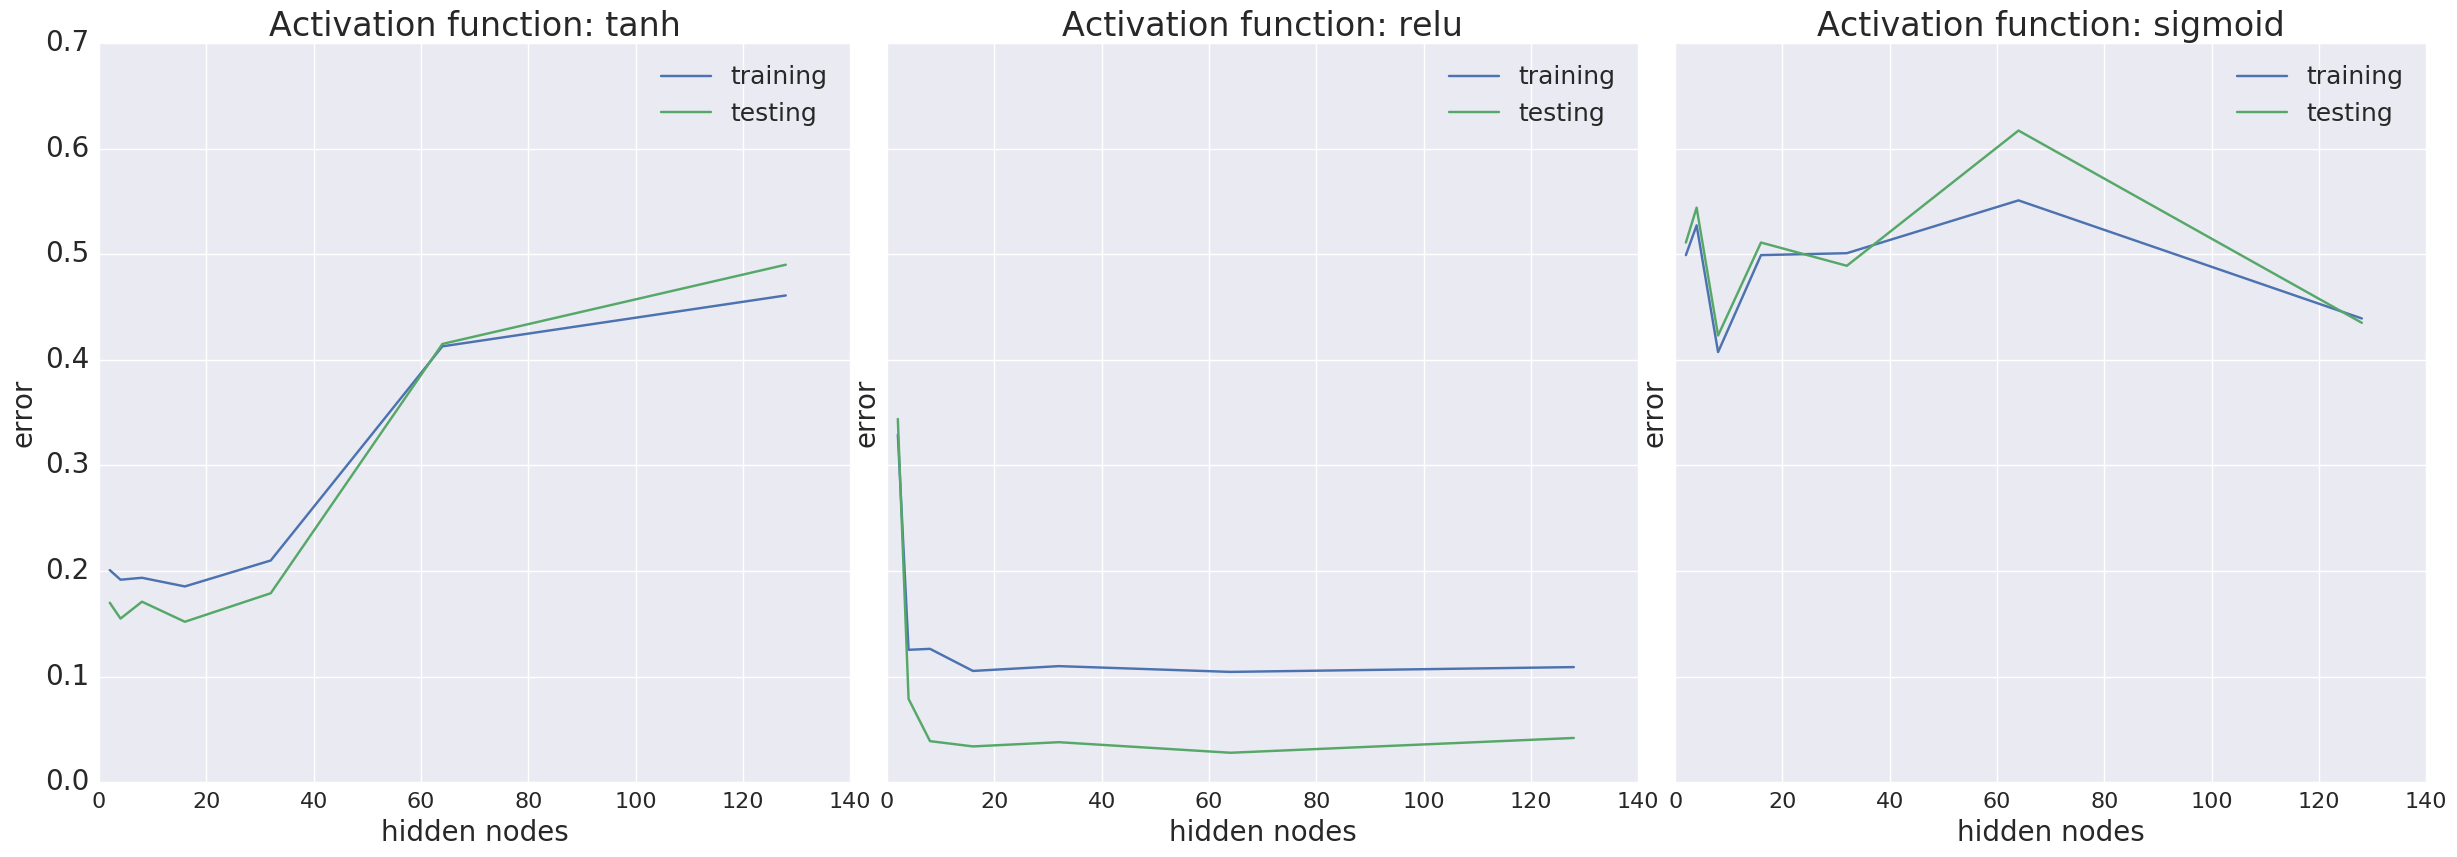

In [24]:
fig, axs = plt.subplots(ncols=3, figsize=(24, 8), sharey=True)
fig.tight_layout()
for i, func_name in enumerate(scores_data.keys()):
    for dataset, points in scores_data[func_name].iteritems():
        axs[i].plot(*zip(*points), label=dataset)
        
    axs[i].set_xlabel('hidden nodes', size=20)
    axs[i].set_ylabel('error', size=20)
    axs[i].legend(loc="upper right", prop={'size':18})  
    axs[i].set_title('Activation function: {}'.format(func_name), size=24)
    axs[i].yaxis.set_tick_params(labelsize=20)
    axs[i].xaxis.set_tick_params(labelsize=16)

De acuerdo a los resultados presentados por tres gráficas de arriba, se puede concluir que agregar mayor complejidad a los modelos no resulta necesariamente en una mejora en la calidad de las predicciones. 

En el primer caso, con función de activación tangencial, el mínimo error se alcanza con 16 nodos en la capa oculta. Posteriormente, las predicciones del modelo comienzan a degradarse. 

En el segundo caso, con función de activación relu, el error disminuye bastante considerando que el máximo se alcanza con los dos nodos y el mínimo con 8. Posterior a eso, el error se estabiliza en $\approx 0.1$ para el training set y $\approx 0.04$ para el testing set.

En el tercer caso, el error oscila entre máximos y mínimos. El mínimo se da con 8 nodos en la capa oculta. 

Comparando entre los tres, el modelo preferible sería el con función de activación relu en la capa oculta, puesto que es el que genera un menor error y con el modelo más simple.

In [27]:
def plot_anns(models, X_train, Y_train, X_test, Y_test):    
    if len(models) > 5:
        return
    
    w = 30.0
    h = w/len(models)
    fig, axs = plt.subplots(ncols=len(models), sharex='col', sharey='row', figsize=(w, h))
    fig.tight_layout()
    
    for i, model in enumerate(models):        
        loss, accu = model.evaluate(X_test, Y_test, verbose=0)
        axs[i].scatter(X_train[:,0], X_train[:,1], s=5, c=Y_train, zorder=10, cmap='gray')
        axs[i].scatter(X_test[:,0], X_test[:,1], s=15, c=Y_test, zorder=10, cmap='gray')
        XX, YY = np.mgrid[-1:1:200j, -1:1:200j]
        Z = model.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
        Z = Z.reshape(XX.shape)
        Zplot = Z > 0.5
        axs[i].pcolormesh(XX, YY, Zplot, cmap='YlGn')
        axs[i].contour(XX, YY, Z, alpha=1, colors=['red', 'k', 'red'], linestyles=['--', '-', '--'], levels=[-1, 0, 1])
        axs[i].set_title('Hidden nodes: {}'.format(2**(i+1)), size=30)
        axs[i].set_xlabel('Testing score: {}'.format(accu), size=30)

#### Función de activación sigmoidal

In [29]:
plot_anns(ann_models['sigmoid'], X_train, Y_train, X_test, Y_test)

#### Función de activación relu

In [30]:
plot_anns(ann_models['relu'], X_train, Y_train, X_test, Y_test)

#### Función de activación tangencial

39648/40000 [============================>.] - ETA: 0s

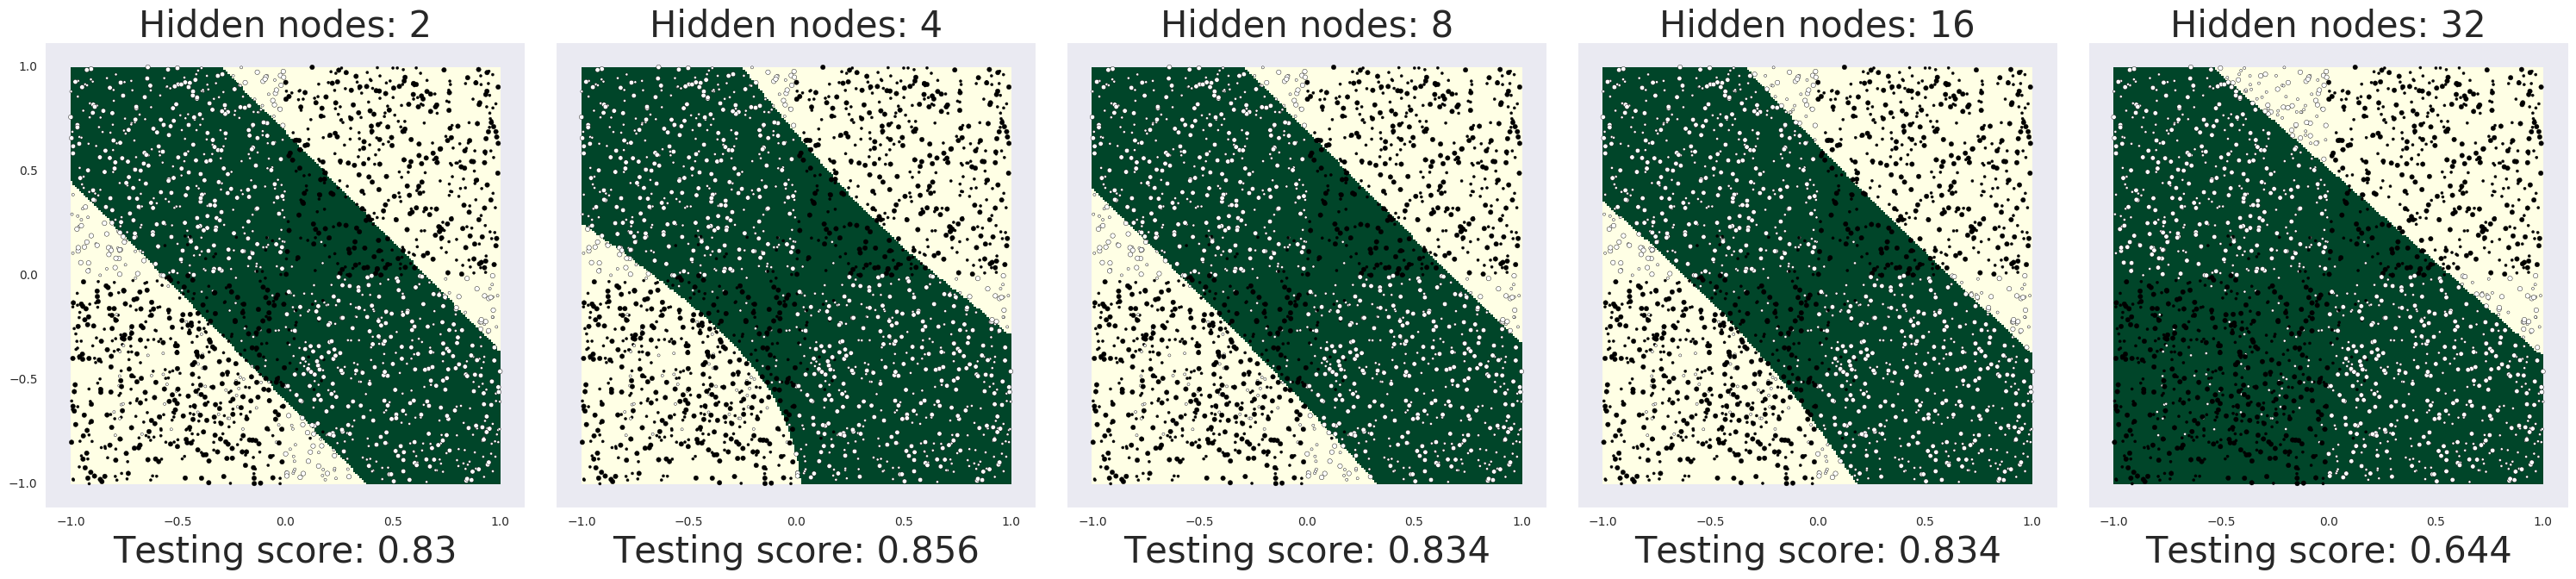

In [40]:
plot_anns(ann_models['tanh'], X_train, Y_train, X_test, Y_test)

### f. Árbol de clasificación de 1 nivel (Stump) 

In [36]:
from sklearn.tree import DecisionTreeClassifier as Tree
clf = Tree(criterion='gini', splitter='best', random_state=0, max_depth=1)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print "Testing accuracy: {}".format(accuracy_score(Y_test, Y_pred))
print "Testing precision: {}".format(precision_score(Y_test, Y_pred))
print "Testing recall: {}".format(recall_score(Y_test, Y_pred))
print "Tree max depth: {}".format(clf.tree_.max_depth)

Testing accuracy: 0.489
Testing precision: 0.5
Testing recall: 0.317025440313
Tree max depth: 1


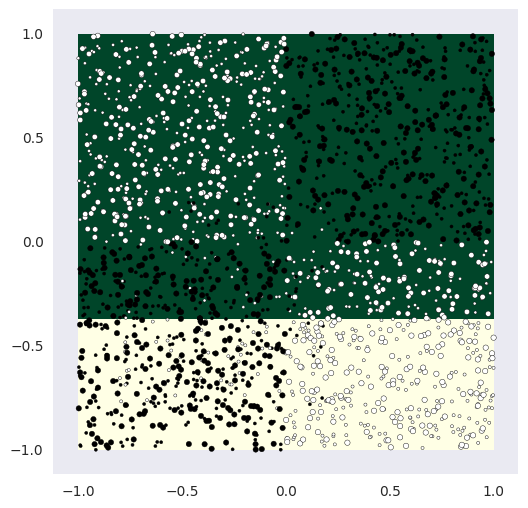

In [37]:
plot_classifier(clf, X_train, Y_train, X_test, Y_test, 'tree')

In [40]:
clf = Tree(criterion='gini', splitter='random', random_state=0, max_depth=1)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print "Testing accuracy: {}".format(accuracy_score(Y_test, Y_pred))
print "Testing precision: {}".format(precision_score(Y_test, Y_pred))
print "Testing recall: {}".format(recall_score(Y_test, Y_pred))
print "Tree max depth: {}".format(clf.tree_.max_depth)

Testing accuracy: 0.491
Testing precision: 0.526315789474
Testing recall: 0.0391389432485
Tree max depth: 1


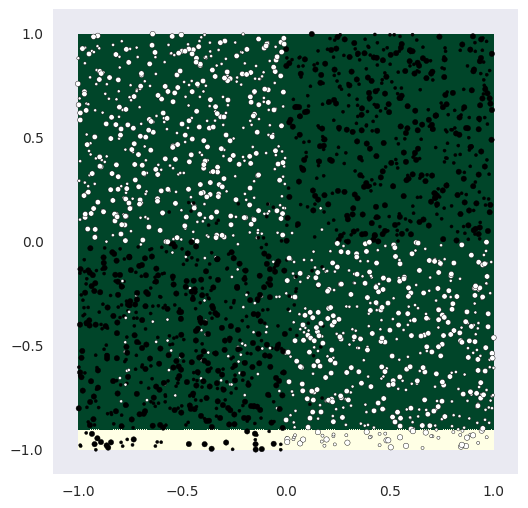

In [41]:
plot_classifier(clf, X_train, Y_train, X_test, Y_test, 'tree')

In [38]:
clf = Tree(criterion='entropy', splitter='best', random_state=0, max_depth=1)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print "Testing accuracy: {}".format(accuracy_score(Y_test, Y_pred))
print "Testing precision: {}".format(precision_score(Y_test, Y_pred))
print "Testing recall: {}".format(recall_score(Y_test, Y_pred))
print "Tree max depth: {}".format(clf.tree_.max_depth)

Testing accuracy: 0.486
Testing precision: 0.333333333333
Testing recall: 0.00587084148728
Tree max depth: 1


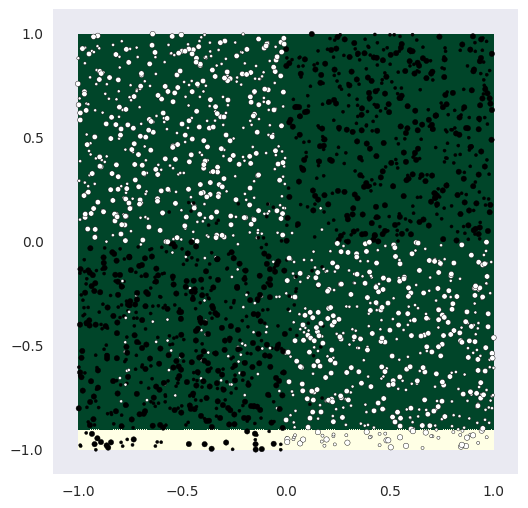

In [42]:
plot_classifier(clf, X_train, Y_train, X_test, Y_test, 'tree')

In [43]:
clf = Tree(criterion='entropy', splitter='random', random_state=0, max_depth=1)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print "Testing accuracy: {}".format(accuracy_score(Y_test, Y_pred))
print "Testing precision: {}".format(precision_score(Y_test, Y_pred))
print "Testing recall: {}".format(recall_score(Y_test, Y_pred))
print "Tree max depth: {}".format(clf.tree_.max_depth)

Testing accuracy: 0.491
Testing precision: 0.526315789474
Testing recall: 0.0391389432485
Tree max depth: 1


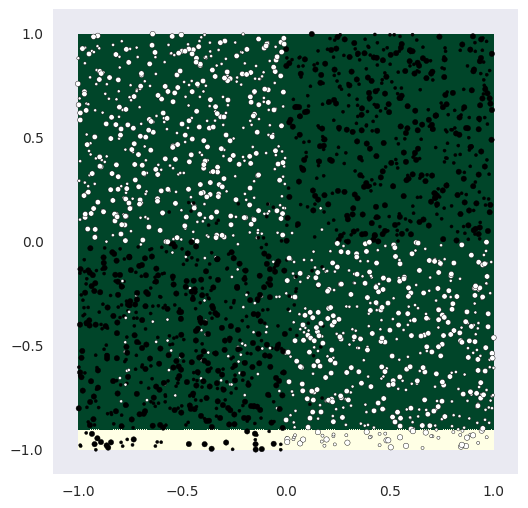

In [44]:
plot_classifier(clf, X_train, Y_train, X_test, Y_test, 'tree')

### g. Árbol de clasificación con múltiples niveles

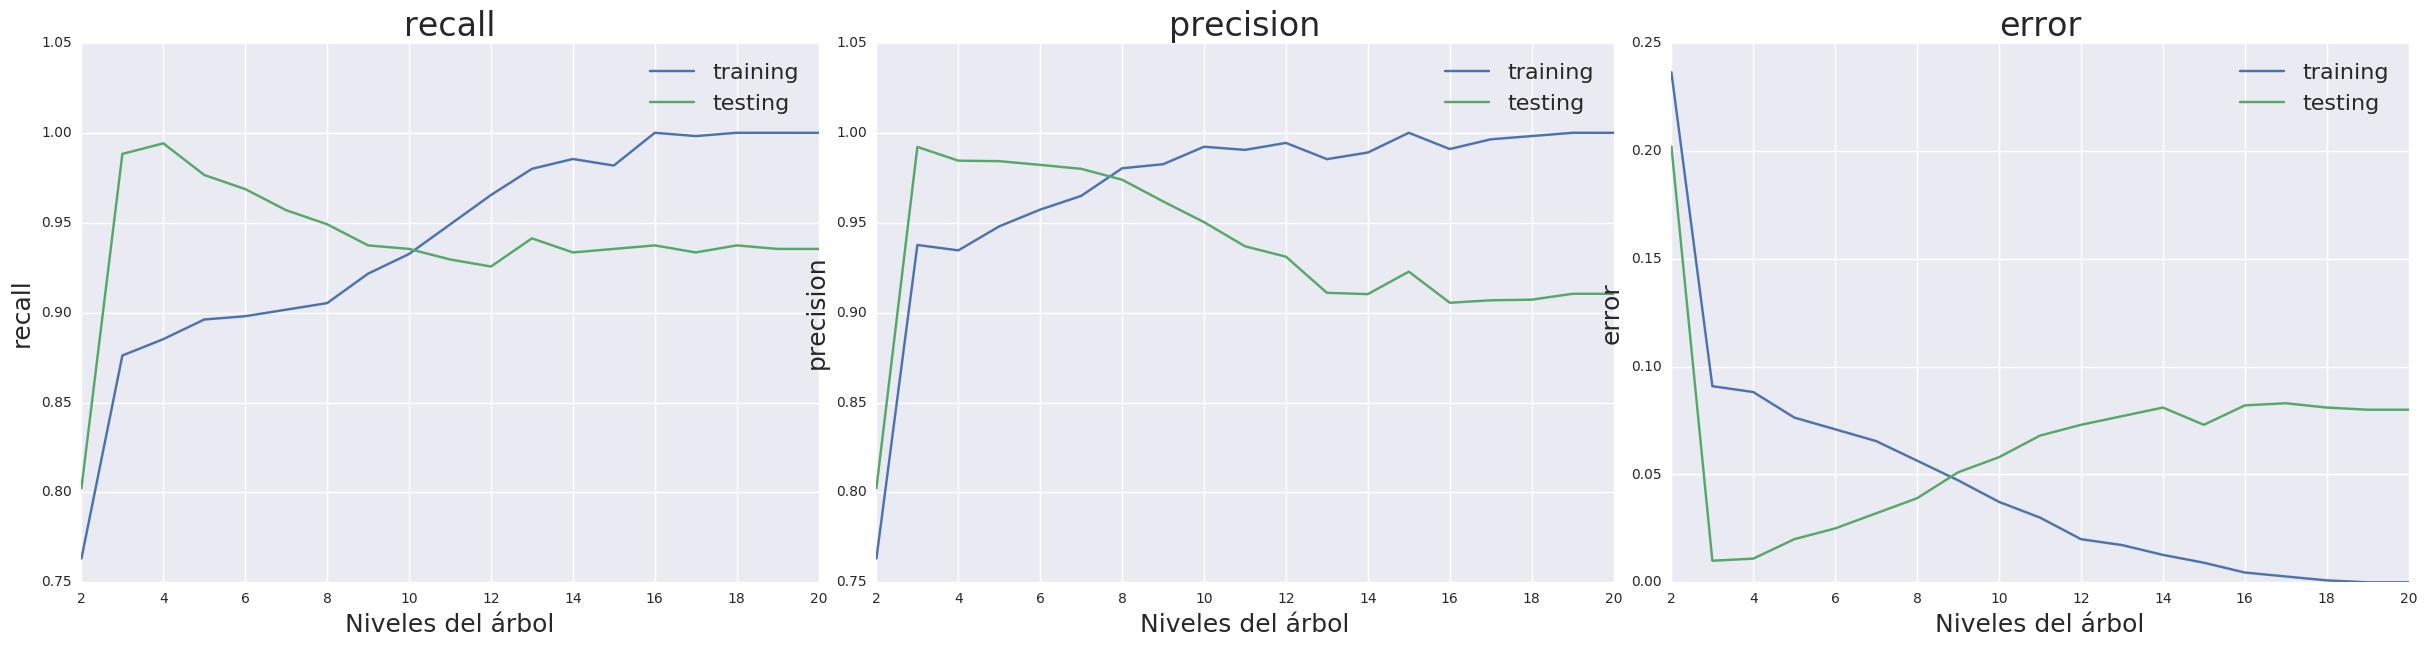

In [67]:
levels = np.arange(2, 21)
fig, axs = plt.subplots(ncols=3, figsize=(24, 6))
fig.tight_layout()
scores_data = {'error':{'training':[], 'testing':[]}, 
               'precision':{'training':[], 'testing':[]}, 
               'recall':{'training':[], 'testing':[]}} 
tree_models = []

for l in levels: 
    clf = Tree(criterion='gini', splitter='best', random_state=0)
    clf.set_params(max_depth=l)
    clf.fit(X_train, Y_train)
    tree_models.append(clf)
    
    # Training set
    Y_pred = clf.predict(X_train)
    scores_data['error']['training'].append((l, 1 - accuracy_score(Y_train, Y_pred)))
    scores_data['precision']['training'].append((l, precision_score(Y_train, Y_pred)))
    scores_data['recall']['training'].append((l, recall_score(Y_train, Y_pred)))
    
    # Testing set
    Y_pred = clf.predict(X_test)
    scores_data['error']['testing'].append((l, 1 - accuracy_score(Y_test, Y_pred)))
    scores_data['precision']['testing'].append((l, precision_score(Y_test, Y_pred)))
    scores_data['recall']['testing'].append((l, recall_score(Y_test, Y_pred)))
    
for i, score in enumerate(scores_data.keys()):
    for dataset, points in scores_data[score].iteritems():
        axs[i].plot(*zip(*points), label=dataset)
        
    axs[i].set_xlabel(u'Niveles del árbol', size=18)
    axs[i].set_ylabel(score, size=18)
    axs[i].legend(loc="upper right", prop={'size':16})  
    axs[i].set_title(score, size=24)

In [68]:
def plot_trees(models, X_train, Y_train, X_test, Y_test, levels_selection):    
    fig, axs = plt.subplots(ncols=5, sharex='col', sharey='row', figsize=(30, 6))
    fig.tight_layout()
    
    for i, level in enumerate(levels_selection):        
        clf = models[i]
        score = clf.score(X_test, Y_test)
        axs[i].scatter(X_train[:,0], X_train[:,1], s=5, c=Y_train, zorder=10, cmap='gray')
        axs[i].scatter(X_test[:,0], X_test[:,1], s=15, c=Y_test, zorder=10, cmap='gray')
        XX, YY = np.mgrid[-1:1:200j, -1:1:200j]
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
        Z = Z.reshape(XX.shape)        
        Zplot = Z > 0.5
        axs[i].pcolormesh(XX, YY, Zplot, cmap='YlGn')
        axs[i].contour(XX, YY, Z, alpha=1, colors=['red', 'k', 'red'], linestyles=['--', '-', '--'], levels=[-1, 0, 1])
        axs[i].set_title('Tree levels: {}'.format(level), size=30)
        axs[i].set_xlabel('Testing score: {0:.4f}'.format(score), size=30)

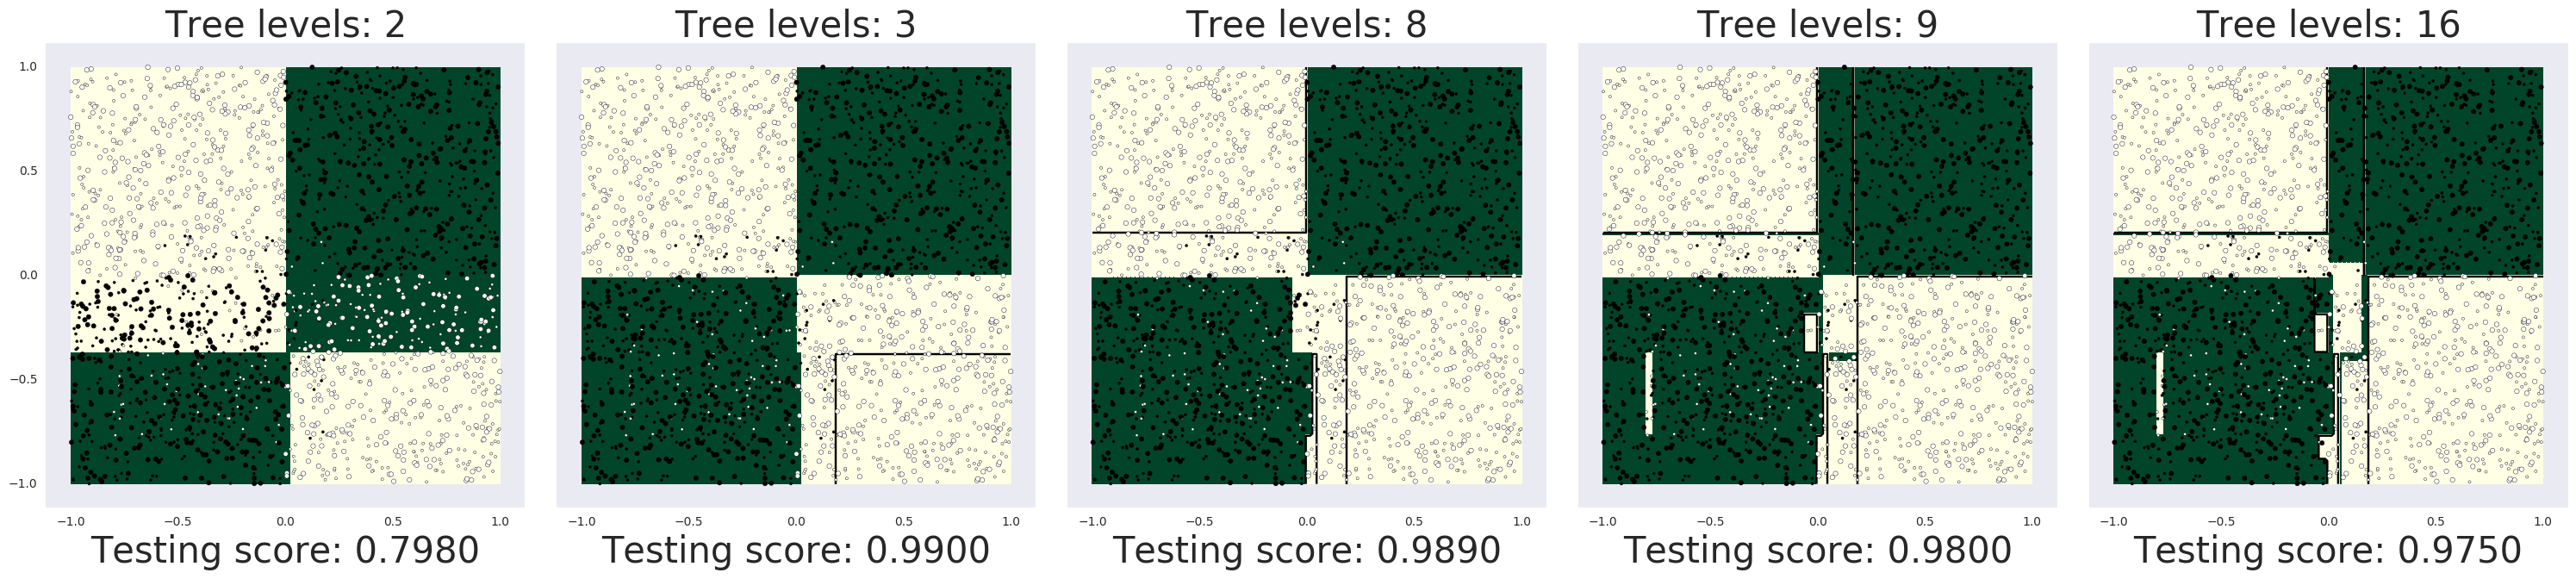

In [71]:
plot_trees(tree_models, X_train, Y_train, X_test, Y_test, [2, 3, 8, 9, 16])